# Latent Noise Imputation for multivariate time series where one is hidden

In [1]:
#@title Load Packages
# TYPE HINTS
from typing import Tuple, Optional, Dict, Callable, Union

# JAX SETTINGS
import jax
import jax.numpy as np
import jax.random as random
import numpyro
import numpyro.distributions as dist
import pandas as pd
import seaborn as sns
from numpyro.infer import SVI

# NUMPY SETTINGS
import numpy as onp
onp.set_printoptions(precision=3, suppress=True)

# MATPLOTLIB Settings
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# SEABORN SETTINGS
import seaborn as sns
sns.set_context(context='talk',font_scale=0.7)

# PANDAS SETTINGS
import pandas as pd
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

# LOGGING SETTINGS
import sys
import logging
logging.basicConfig(
    level=logging.INFO, 
    stream=sys.stdout,
    format='%(asctime)s:%(levelname)s:%(message)s'
)
logger = logging.getLogger()
#logger.setLevel(logging.INFO)

import tqdm

%load_ext autoreload
%autoreload 2

# Read in data

In [2]:
pwd

'/home/emiliano/Documents/ISP/proyectos/causality/causaLearner_R_pkg/causaLearner/pkg_causaLearner/experiments/CMEM_ln_ts'

In [84]:
cd "/home/emiliano/Documents/ISP/proyectos/causality/causaLearner_R_pkg/causaLearner/data/timeSeries/latentNoise_xyz" 

/home/emiliano/Documents/ISP/proyectos/causality/causaLearner_R_pkg/causaLearner/data/timeSeries/latentNoise_xyz


In [85]:
df = pd.read_csv("ts_latentNoise_xyz_4")

In [86]:
df.shape

(100, 5)

In [87]:
df[["x1","y1"]].head()

,x1,y1
0,0.025150,-0.359296
1,-0.056995,-0.374173
2,0.184774,-0.320722
3,-0.507299,-0.276530
4,0.671643,-0.365379


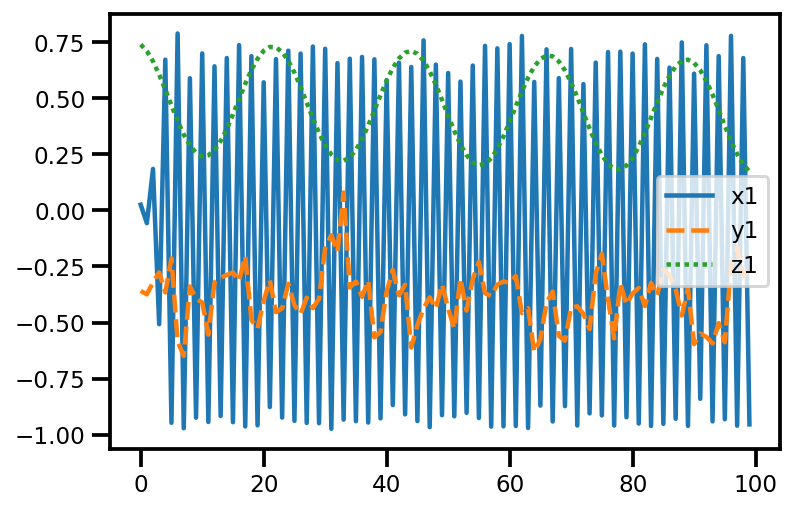

In [88]:
sns.lineplot(data=df[["x1","y1","z1"]])

# Define functions for latent noise imputation

First jax-vectorized kernel functions

In [89]:
#@title Kernel Functions

# Squared Euclidean Distance Formula
@jax.jit
def sqeuclidean_distance(x, y):
    return np.sum((x-y)**2)

# RBF Kernel
@jax.jit
def rbf_kernel(params, x, y):
    return np.exp( - params['gamma'] * sqeuclidean_distance(x, y))
    
# Covariance Matrix
def covariance_matrix(kernel_func, x, y):
    mapx1 = jax.vmap(lambda x, y: kernel_func(x, y), in_axes=(0, None), out_axes=0)
    mapx2 = jax.vmap(lambda x, y: mapx1(x, y), in_axes=(None, 0), out_axes=1)
    return mapx2(x, y)

# Covariance Matrix
def rbf_kernel_matrix(params, x, y):
    mapx1 = jax.vmap(lambda x, y: rbf_kernel(params, x, y), in_axes=(0, None), out_axes=0)
    mapx2 = jax.vmap(lambda x, y: mapx1(x, y), in_axes=(None, 0), out_axes=1)
    return mapx2(x, y)

Centering, hsic and MSE functions

In [90]:
from jax.scipy import linalg

In [91]:
def centering(K):
    n_samples = K.shape[0]
    logging.debug(f"N: {n_samples}")
    logging.debug(f"I: {np.ones((n_samples, n_samples)).shape}")
    H = np.eye(K.shape[0],) - (1 / n_samples) * np.ones((n_samples, n_samples))
    return np.dot(K, H)

def hsic(K_x, K_z):
    K_x = centering(K_x)
    K_z = centering(K_z)
    return np.sum(K_x * K_z) / np.linalg.norm(K_x) / np.linalg.norm(K_z)

def mse(y, y_hat):
    return np.sum((y-y_hat)**2)

Function to calculate kernel ridge regression weights based on lengthscale for input $x$ and hidden variable $z$

In [92]:
def kernel_mat(params, K_x, Ztr, Zte, y):

    #sigma = 1.0
    #sigmaX <- 1/median(as.numeric(dist(unique(x))^2))
    
    distsZ = covariance_matrix(sqeuclidean_distance, Ztr, Ztr)
    sigma = 1/np.median(distsZ)

    K_z = rbf_kernel_matrix({'gamma': sigma}, Zte, Ztr)

    # since we use rbf kernels this corresponds to the kernel where
    # (x,z) is the (stacked) feature. 
    K = K_x * K_z

    # cho factor the cholesky 
    L = linalg.cho_factor(K + params['lambda'] * np.eye(K.shape[0]))

    # weights
    weights = linalg.cho_solve(L, y)

    # save the params


    # return the predictions
    return K, weights, K_z

Lets try out this function with imported data

In [93]:
x = df[["x1","y1"]]
z = df[["z1"]]
y = df[["yt"]]
x=x.to_numpy()
y=y.to_numpy()
z=z.to_numpy()
print(x.shape)
print(y.shape)
print(z.shape)
(type(x))
#x = onp.random.randn(100,2)
#print(x.shape)
#print(type(x))
K_x = rbf_kernel_matrix({'gamma': 1.0}, x,x)


(100, 2)
(100, 1)
(100, 1)


In [94]:
params_real = {'lambda': 0.01, 'gamma': 1.0}
K, alpha , K_z = kernel_mat(params_real, K_x, z,z, y)
cka_val = hsic(K_x, K_z)
cka_val

DeviceArray(0.007, dtype=float32)

Given a model, defined in params $Z$ and $\lambda$ ($\alpha$ is assumed to be the krr least squares estimate so is not explicitly part of the model) we calculate the different components of the penalized loss: square loss, smoothness penalty and hsic penalty between hidden variable $z$ and input $x$

In [95]:
# for reporting purposes give back 3 terms separatley
def model(params, K_x, y):

    

    # find kernel stuffs
    K, weights , K_z  = kernel_mat(params, K_x, params['z'], params['z'], y)

    # find y
    #y_hat = np.dot(weights, K)
    y_hat = K @ weights
    
    # hsic
    hsic_val = hsic(K_x, K_z)

    # calculate norm
    penalize = np.linalg.norm(weights.T @ K @ weights)
    monitor = {}
    monitor = {
        'mse': mse(y, y_hat),
        'penalty': penalize,
        'hsic': hsic_val,
        'lambda': params['lambda'][0],
        'K_z_e': np.min(linalg.eigh(K_z)[0]),
        'K_e': np.min(linalg.eigh(K)[0]),

    }

    return monitor


Calculate the total loss for gradient calculating purposes

In [96]:
    
# this for gradient calculating purposes    
def loss(params, K_x, y):

    beta = 10.
    params['lambda'] = np.array([0.01])

    # find kernel stuffs
    K, weights , K_z  = kernel_mat(params, K_x, params['z'], params['z'], y)

    #print('weights shape',weights.shape)
    #print('K shape', K.shape)
    # find y
    #y_hat = np.dot(weights, K)
    y_hat = K @ weights
    
    # hsic
    hsic_val = hsic(K_x, K_z)

    # calculate norm
    penalize = np.linalg.norm(weights.T @ K @ weights)

    # calcualte compute loss
    loss_value = mse(y, y_hat) + params['lambda'] * penalize + beta * hsic_val

    return loss_value[0]

For an arbitrary $z$ calculate the loss and loss gradient

In [97]:
params = {
    'z': z,
    # 'lambda': np.array([0.01]),
}
x = df[["x1","y1"]]
y = df[["yt"]]
x=x.to_numpy()
y=y.to_numpy()
K_x = rbf_kernel_matrix({'gamma': 1.0}, x,x)

Z = np.array(0.5 * onp.random.randn(100))
dloss = jax.grad(loss, )
print('loss',loss(params, K_x, y))
print('gradient loss', dloss(params, K_x, y))

loss 0.5542885
gradient loss {'lambda': array([0.], dtype=float32), 'z': DeviceArray([[-0.05 ],
             [ 0.423],
             [ 0.069],
             [ 0.009],
             [ 0.105],
             [ 0.032],
             [ 0.009],
             [ 0.115],
             [-0.01 ],
             [ 0.05 ],
             [ 0.253],
             [-0.017],
             [ 0.016],
             [ 0.009],
             [-0.005],
             [ 0.17 ],
             [-0.009],
             [-0.029],
             [ 0.009],
             [-0.148],
             [-0.084],
             [-0.081],
             [ 0.078],
             [-0.368],
             [ 0.084],
             [ 0.003],
             [ 0.045],
             [-0.021],
             [-0.012],
             [ 0.093],
             [-0.239],
             [-0.12 ],
             [ 0.081],
             [-0.037],
             [-0.026],
             [ 0.024],
             [ 0.055],
             [-0.396],
             [-0.059],
             [ 0.205],
       

# Optimization of $Z$

Lets initalize parameters and lists where we collect progress on loss

In [98]:
# stochastic gradient descent 
learning_rate = 0.1
epochs = 250
monitors_xy = {
    'loss': list(),
    'hsic': list(),
    'errs': list(),
    'lambda': list(),
    'K_z_e': list(),
    'K_e': list()
}

monitors_yx = {
    'loss': list(),
    'hsic': list(),
    'errs': list(),
    'lambda': list(),
    'K_z_e': list(),
    'K_e': list()
}


rng_key = random.PRNGKey(10)

# initialize parameters
params_xy = {
    'z': np.array(0.5 * onp.random.randn(100,1)),
    'lambda': np.array([0.01]),

}

params_yx = {
    'z': np.array(0.5 * onp.random.randn(100,1)),
    'lambda': np.array([0.01]),

}


In [100]:
x1 = df[["x1","y1"]]
y = df[["yt"]]
x = df[["xt"]]
x1=x1.to_numpy()
x=x.to_numpy()
y=y.to_numpy()
distsX = covariance_matrix(sqeuclidean_distance, x1, x1)
sigma = 1/np.median(distsX)
K_x = rbf_kernel_matrix({'gamma': sigma}, x1,x1)



Lets obtain $Z$ in $x \rightarrow y$ direction, i.e. where $x$ is the input and $y$ the output (ground truth)

In [101]:
# loop through epochs
with tqdm.trange(epochs) as pbar:
    for iteration in pbar:
        monitor = model(params_xy, K_x, y)
        monitors_xy['hsic'].append(monitor['hsic'])
        monitors_xy['errs'].append(monitor['mse'])
        monitors_xy['lambda'].append(monitor['lambda'])
        monitors_xy['K_z_e'].append(monitor['K_z_e'])
        monitors_xy['K_e'].append(monitor['K_e'])
        # get the gradient of the loss 
        grad_params = dloss(params_xy, K_x, y)
        # print(grad_params)

        # update the parameters
        # for name, value in grad_params.items():
        #     params[name] = params[name] - learning_rate * jnp.mean(value, axis=0)
        # Update weight params
        # params['Z'] = params['Z'] - learning_rate * np.mean(grad_params['Z'], axis=0)
        params_xy['z'] = params_xy['z'] - learning_rate * grad_params['z']
        params_xy['lambda'] = params_xy['lambda'] - learning_rate * grad_params['lambda']

        # params['lambda'] = params['lambda'] - learning_rate * np.mean(grad_params['lambda'], axis=0)
        # append loss
        loss_val = loss(params_xy, K_x, y)

        postfix = {
            "loss":f"{loss_val:.4f}", 
            "hsic":f"{monitor['hsic']:.4f}",
            "mse":f"{monitor['mse']:.4f}",
            "lambda":f"{monitor['lambda']:.4f}"
            }
        pbar.set_postfix(postfix)
        monitors_xy['loss'].append(loss_val)

100%|██████████| 250/250 [00:19<00:00, 12.71it/s, loss=0.0771, hsic=-0.0001, mse=0.0174, lambda=0.0100]


... and in the $y->x$ directin

In [102]:
# loop through epochs
with tqdm.trange(epochs) as pbar:
    for iteration in pbar:
        monitor = model(params_yx, K_x, x)
        monitors_yx['hsic'].append(monitor['hsic'])
        monitors_yx['errs'].append(monitor['mse'])
        monitors_yx['lambda'].append(monitor['lambda'])
        monitors_yx['K_z_e'].append(monitor['K_z_e'])
        monitors_yx['K_e'].append(monitor['K_e'])
        # get the gradient of the loss 
        grad_params = dloss(params_yx, K_x, x)
        # print(grad_params)

        # update the parameters
        # for name, value in grad_params.items():
        #     params[name] = params[name] - learning_rate * jnp.mean(value, axis=0)
        # Update weight params
        # params['Z'] = params['Z'] - learning_rate * np.mean(grad_params['Z'], axis=0)
        params_yx['z'] = params_yx['z'] - learning_rate * grad_params['z']
        params_yx['lambda'] = params_yx['lambda'] - learning_rate * grad_params['lambda']

        # params['lambda'] = params['lambda'] - learning_rate * np.mean(grad_params['lambda'], axis=0)
        # append loss
        loss_val = loss(params_yx, K_x, x)

        postfix = {
            "loss":f"{loss_val:.4f}", 
            "hsic":f"{monitor['hsic']:.4f}",
            "mse":f"{monitor['mse']:.4f}",
            "lambda":f"{monitor['lambda']:.4f}"
            }
        pbar.set_postfix(postfix)
        monitors_yx['loss'].append(loss_val)

100%|██████████| 250/250 [00:23<00:00, 10.52it/s, loss=0.0478, hsic=-0.0019, mse=0.0071, lambda=0.0100]


# Results

Lets graph the overall **LOSS** as a function of the epoch for both directions

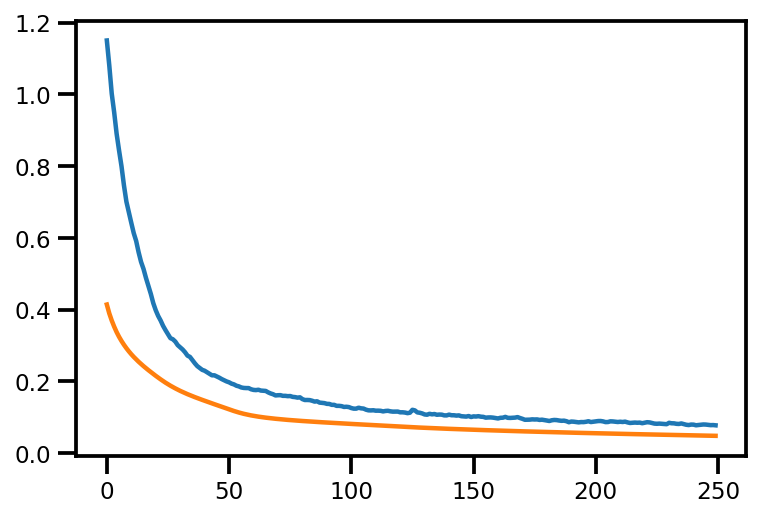

In [103]:
plt.plot(monitors_xy['loss'])
plt.plot(monitors_yx['loss'])

... and **squared errors**

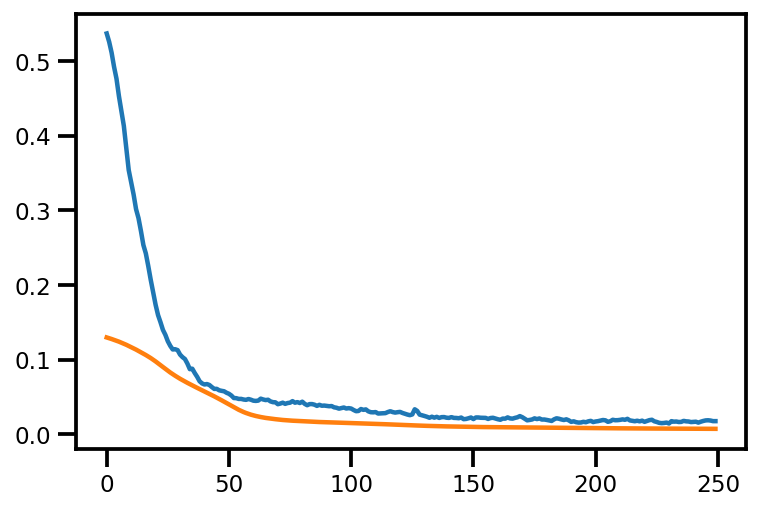

In [104]:
plt.plot(monitors_xy['errs'])
plt.plot(monitors_yx['errs'])

... and **HSIC**

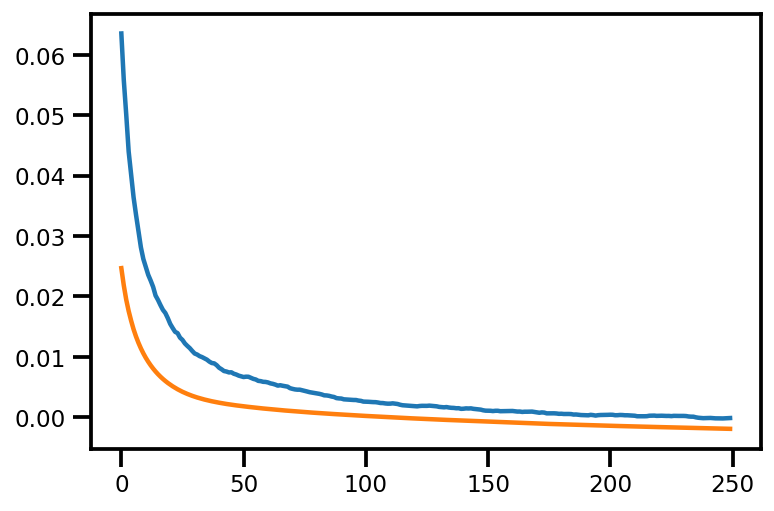

In [105]:
plt.plot(monitors_xy['hsic'])
plt.plot(monitors_yx['hsic'])

Lets have a look at $x$ vs $<$

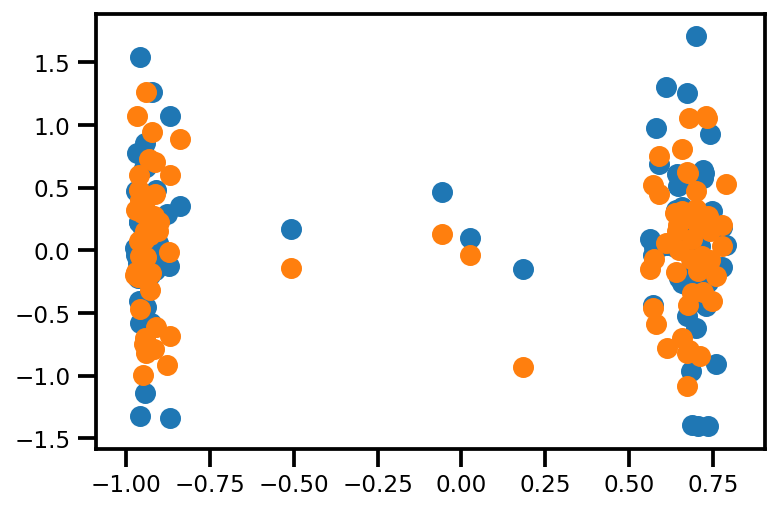

In [109]:
plt.scatter(x1[:,0],params_xy["z"])
plt.scatter(x1[:,0],params_yx["z"])

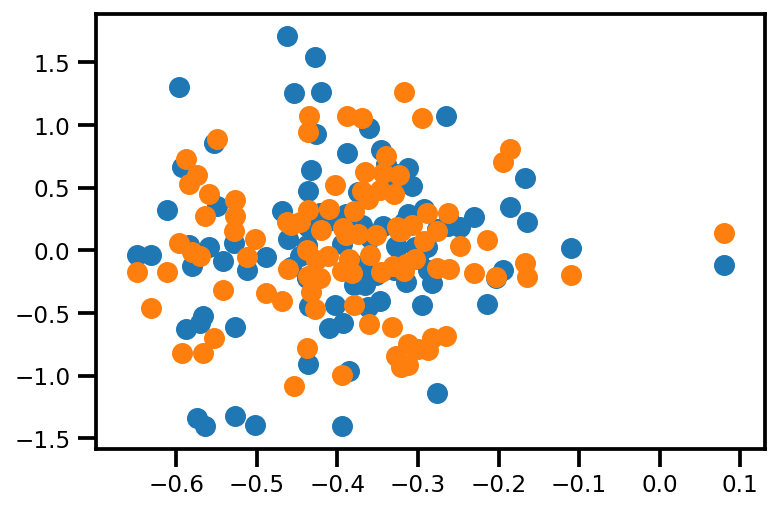

In [110]:
plt.scatter(x1[:,1],params_xy["z"])
plt.scatter(x1[:,1],params_yx["z"])

Lets look at $\hat{z}$ vs $z$

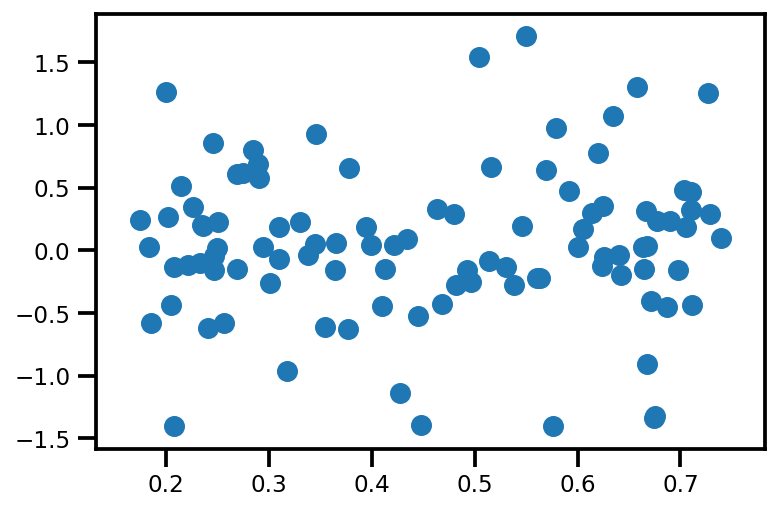

In [111]:
plt.scatter(z,params_xy["z"])

# Write results

lets append $z^{x \rightarrow y}$ and $z^{y \rightarrow x}$ to df and export in .csv format

In [112]:
df.head()

,xt,yt,x1,y1,z1
0,-0.056995,-0.374173,0.025150,-0.359296,0.739393
1,0.184774,-0.320722,-0.056995,-0.374173,0.710094
2,-0.507299,-0.276530,0.184774,-0.320722,0.664313
3,0.671643,-0.365379,-0.507299,-0.276530,0.605545
4,-0.946800,-0.214115,0.671643,-0.365379,0.538290


In [113]:
df2 = pd.DataFrame(params_xy["z"], columns=['z_xy'])
df3 = pd.DataFrame(params_yx["z"], columns=['z_yx'])

In [114]:
df2.head()

,z_xy
0,0.101581
1,0.467681
2,-0.150332
3,0.172267
4,-0.280297


In [115]:
df.join(df2).join(df3).head()

,xt,yt,x1,y1,z1,z_xy,z_yx
0,-0.056995,-0.374173,0.025150,-0.359296,0.739393,0.101581,-0.036065
1,0.184774,-0.320722,-0.056995,-0.374173,0.710094,0.467681,0.132678
2,-0.507299,-0.276530,0.184774,-0.320722,0.664313,-0.150332,-0.926941
3,0.671643,-0.365379,-0.507299,-0.276530,0.605545,0.172267,-0.138430
4,-0.946800,-0.214115,0.671643,-0.365379,0.538290,-0.280297,0.622698


In [116]:
df = df.join(df2).join(df3)
df.head()

,xt,yt,x1,y1,z1,z_xy,z_yx
0,-0.056995,-0.374173,0.025150,-0.359296,0.739393,0.101581,-0.036065
1,0.184774,-0.320722,-0.056995,-0.374173,0.710094,0.467681,0.132678
2,-0.507299,-0.276530,0.184774,-0.320722,0.664313,-0.150332,-0.926941
3,0.671643,-0.365379,-0.507299,-0.276530,0.605545,0.172267,-0.138430
4,-0.946800,-0.214115,0.671643,-0.365379,0.538290,-0.280297,0.622698


In [117]:
cd "/home/emiliano/Documents/ISP/proyectos/causality/causaLearner_R_pkg/causaLearner/data/timeSeries/latentNoise_xyz_est" 

/home/emiliano/Documents/ISP/proyectos/causality/causaLearner_R_pkg/causaLearner/data/timeSeries/latentNoise_xyz_est


In [118]:
df.to_csv(r'\ts_latentNoise_xyz_est_4', index = False)

# Create a function to read, calculate z, and write

First lets define a function to optimze z

In [ ]:
import copy

In [133]:
def optimize_z(monitors, params, K_x, y, epochs):
    # loop through epochs
    params_res = copy.deepcopy(params)
    monitors_res = copy.deepcopy(monitors)
    for i in range(epochs):
        monitor = model(params_res, K_x, y)
        monitors_res['hsic'].append(monitor['hsic'])
        monitors_res['errs'].append(monitor['mse'])
        monitors_res['lambda'].append(monitor['lambda'])
        monitors_res['K_z_e'].append(monitor['K_z_e'])
        monitors_res['K_e'].append(monitor['K_e'])
        # get the gradient of the loss 
        grad_params = dloss(params_res, K_x, y)
        # print(grad_params)

        # update the parameters
        # for name, value in grad_params.items():
        #     params[name] = params[name] - learning_rate * jnp.mean(value, axis=0)
        # Update weight params
        # params['Z'] = params['Z'] - learning_rate * np.mean(grad_params['Z'], axis=0)
        params_res['z'] = params_res['z'] - learning_rate * grad_params['z']
        params_res['lambda'] = params_res['lambda'] - learning_rate * grad_params['lambda']
        loss_val = loss(params_res, K_x, y)

        monitors_res['loss'].append(loss_val)
    
    return monitors_res, params_res

In [134]:
# stochastic gradient descent 
learning_rate = 0.1
epochs = 250
monitors = {
    'loss': list(),
    'hsic': list(),
    'errs': list(),
    'lambda': list(),
    'K_z_e': list(),
    'K_e': list()
}


rng_key = random.PRNGKey(10)

# initialize parameters
params = {
    'z': np.array(0.5 * onp.random.randn(100,1)),
    'lambda': np.array([0.01]),

}

params1 = {
    'z': np.array(0.5 * onp.random.randn(100,1)),
    'lambda': np.array([0.01]),

}

params2 = {
    'z': np.array(0.5 * onp.random.randn(100,1)),
    'lambda': np.array([0.01]),

}


In [163]:
xy1 = df[["x1","y1"]]
x1 = df[["x1"]]
y1 = df[["y1"]]
y = df[["yt"]]
x = df[["xt"]]
xy1=xy1.to_numpy()
x1=x1.to_numpy()
y1=y1.to_numpy()
x=x.to_numpy()
y=y.to_numpy()
distsX = covariance_matrix(sqeuclidean_distance, xy1, xy1)
sigma = 1/np.median(distsX)
K_xy = rbf_kernel_matrix({'gamma': sigma}, xy1,xy1)

distsX = covariance_matrix(sqeuclidean_distance, x1, x1)
sigma = 1/np.median(distsX)
K_x = rbf_kernel_matrix({'gamma': sigma}, x1,x1)

distsX = covariance_matrix(sqeuclidean_distance, y1, y1)
sigma = 1/np.median(distsX)
K_y = rbf_kernel_matrix({'gamma': sigma}, y1,y1)

In [164]:
monitors_xy, params_xy = optimize_z(monitors, params, K_xy, y, epochs)
monitors_yx, params_yx = optimize_z(monitors, params, K_xy, x, epochs)
monitors_yy, params_yy = optimize_z(monitors, params, K_y, y, epochs)
monitors_xx, params_xx = optimize_z(monitors, params, K_x, x, epochs)

In [165]:
print(type(params))
print(type(params_xy))

<class 'dict'>
<class 'dict'>


In [166]:
print(len(params['z']))
print(len(params_xy['z']))

100
100


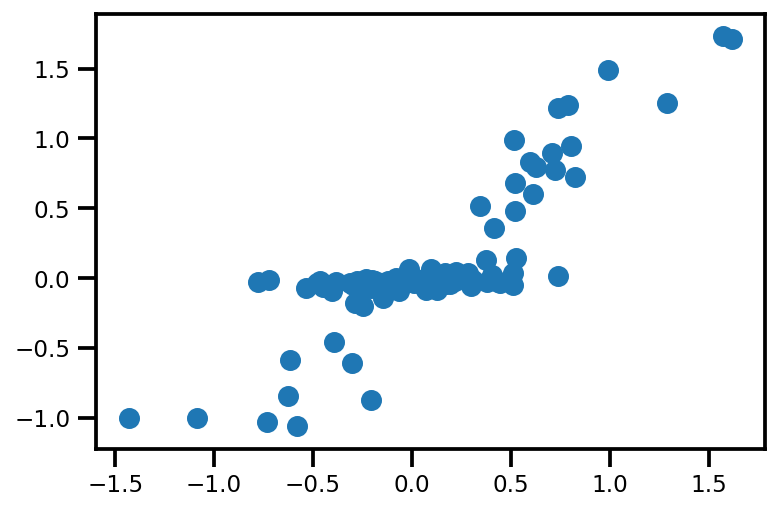

In [167]:
plt.scatter(params['z'],params_xy['z'])

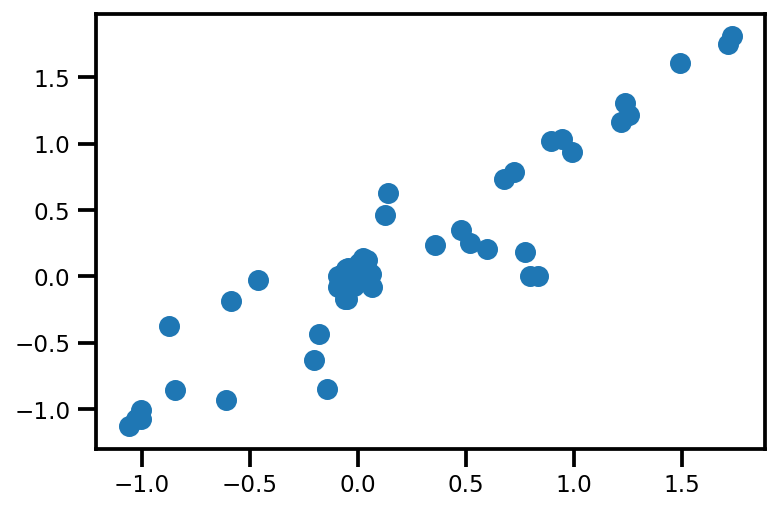

In [168]:
plt.scatter(params_xy['z'],params_yx['z'])

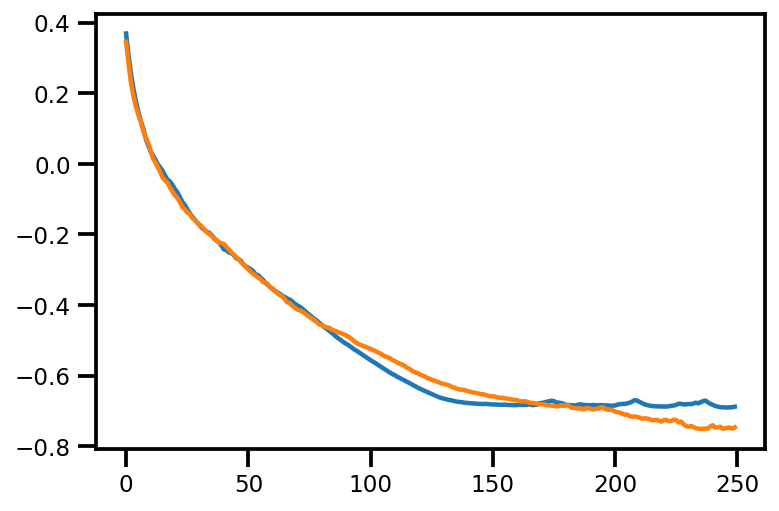

In [169]:
plt.plot(monitors_xy['loss'])
plt.plot(monitors_yx['loss'])

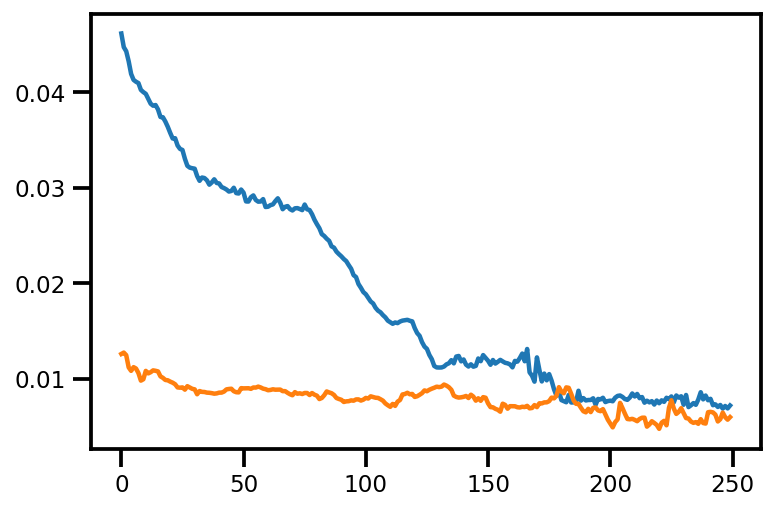

In [170]:
plt.plot(monitors_xy['errs'])
plt.plot(monitors_yx['errs'])

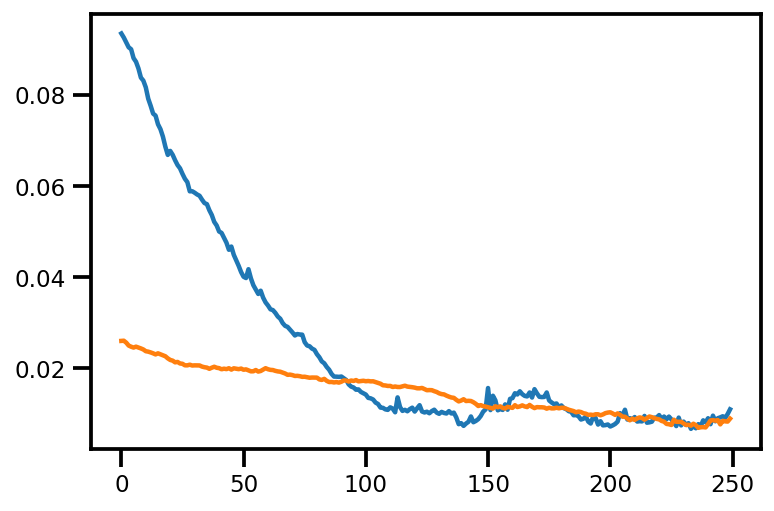

In [171]:
plt.plot(monitors_yy['errs'])
plt.plot(monitors_xx['errs'])

In [173]:
type(monitors_xy['errs'])

list

In [177]:
(np.array(monitors_xy['errs'])+np.array(monitors_xx['errs'])).size

250

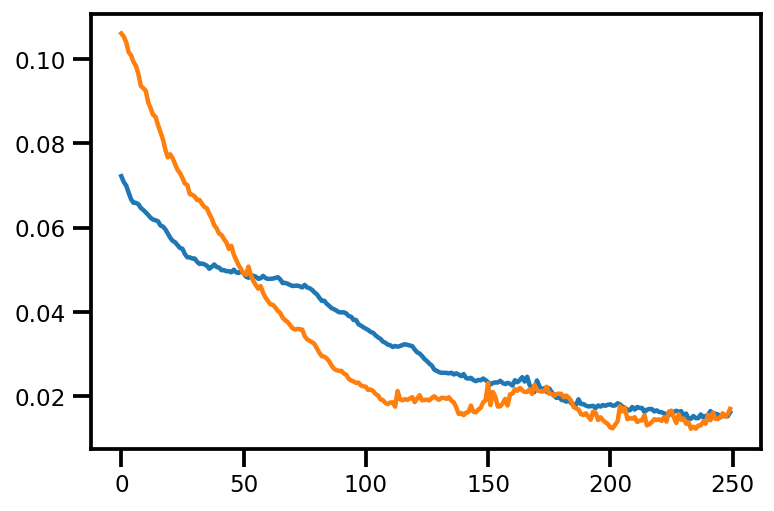

In [179]:
plt.plot(np.array(monitors_xy['errs'])+np.array(monitors_xx['errs']))
plt.plot(np.array(monitors_yx['errs'])+np.array(monitors_yy['errs']))


In [180]:
(np.array(monitors_xy['errs'])+np.array(monitors_xx['errs'])).size

250

In [190]:
print((np.array(monitors_xy['errs'])+np.array(monitors_xx['errs']))[249])
print((np.array(monitors_yx['errs'])+np.array(monitors_yy['errs']))[249])

0.016154196
0.01697868


In [196]:
print((np.array(monitors_xy['errs'])+np.array(monitors_xx['errs']))[249]<(np.array(monitors_yx['errs'])+np.array(monitors_yy['errs']))[249])

True


Now we can loop through 100 data sets, read, optimize and write

In [154]:
reposRead = "/home/emiliano/Documents/ISP/proyectos/causality/causaLearner_R_pkg/causaLearner/data/timeSeries/latentNoise_xyz"
reposWrite = "/home/emiliano/Documents/ISP/proyectos/causality/causaLearner_R_pkg/causaLearner/data/timeSeries/latentNoise_xyz_est"

In [197]:
import os
hit = list()

In [199]:
with tqdm.trange(100) as pbar:
    for i in pbar:
        os.chdir(reposRead)
        df = pd.read_csv("ts_latentNoise_xyz_"+str(i+1))
        xy1 = df[["x1","y1"]]
        y1 = df[["x1"]]
        x1 = df[["y1"]]
        x = df[["xt"]]
        y = df[["yt"]]
        xy1=xy1.to_numpy()
        x1=x1.to_numpy()
        y1=y1.to_numpy()
        x=x.to_numpy()
        y=y.to_numpy()
        
        distsX = covariance_matrix(sqeuclidean_distance, xy1, xy1)
        sigma = 1/np.median(distsX)
        K_xy = rbf_kernel_matrix({'gamma': sigma}, xy1,xy1)
        
        distsX = covariance_matrix(sqeuclidean_distance, x1, x1)
        sigma = 1/np.median(distsX)
        K_x = rbf_kernel_matrix({'gamma': sigma}, x1,x1)
        
        distsX = covariance_matrix(sqeuclidean_distance, y1, y1)
        sigma = 1/np.median(distsX)
        K_y = rbf_kernel_matrix({'gamma': sigma}, y1,y1)
        
        monitors_xy, params_xy = optimize_z(monitors, params, K_xy, y, epochs)
        monitors_yx, params_yx = optimize_z(monitors, params, K_xy, x, epochs)
        monitors_xx, params_xx = optimize_z(monitors, params, K_x, x, epochs)
        monitors_yy, params_yy = optimize_z(monitors, params, K_y, y, epochs)
        
        aux_hit = (np.array(monitors_xy['errs'])+np.array(monitors_xx['errs']))[249]<(np.array(monitors_yx['errs'])+np.array(monitors_yy['errs']))[249]
        hit.append(aux_hit)
        print("hit", i, ": ", aux_hit)
        
        df2 = pd.DataFrame(params_xy["z"], columns=['z_xy'])
        df3 = pd.DataFrame(params_yx["z"], columns=['z_yx'])
        df4 = pd.DataFrame(params_xx["z"], columns=['z_xx'])
        df5 = pd.DataFrame(params_yy["z"], columns=['z_yy'])
        df = df.join(df2).join(df3).join(df4).join(df5)
        os.chdir(reposWrite)
        df.to_csv(r'ts_latentNoise_xyz_est_'+str(i+1), index = False)


  1%|          | 1/100 [02:24<3:58:29, 144.54s/it]

hit 0 :  False


  2%|▏         | 2/100 [04:52<3:57:50, 145.62s/it]

hit 1 :  True


  3%|▎         | 3/100 [07:14<3:53:21, 144.35s/it]

hit 2 :  True


  4%|▍         | 4/100 [09:33<3:48:28, 142.79s/it]

hit 3 :  False


  5%|▌         | 5/100 [11:44<3:40:24, 139.20s/it]

hit 4 :  False


  6%|▌         | 6/100 [13:58<3:35:48, 137.75s/it]

hit 5 :  False


  7%|▋         | 7/100 [16:15<3:33:22, 137.66s/it]

hit 6 :  False


  8%|▊         | 8/100 [18:23<3:26:39, 134.78s/it]

hit 7 :  True


  9%|▉         | 9/100 [20:20<3:16:11, 129.36s/it]

hit 8 :  False


 10%|█         | 10/100 [22:17<3:08:14, 125.49s/it]

hit 9 :  True


 11%|█         | 11/100 [24:13<3:02:19, 122.91s/it]

hit 10 :  True


 12%|█▏        | 12/100 [26:09<2:56:48, 120.55s/it]

hit 11 :  True


 13%|█▎        | 13/100 [28:03<2:52:12, 118.76s/it]

hit 12 :  True


 14%|█▍        | 14/100 [29:58<2:48:34, 117.62s/it]

hit 13 :  False


 15%|█▌        | 15/100 [31:53<2:45:28, 116.80s/it]

hit 14 :  False


 16%|█▌        | 16/100 [33:47<2:42:33, 116.12s/it]

hit 15 :  False


 17%|█▋        | 17/100 [35:43<2:40:14, 115.84s/it]

hit 16 :  True


 18%|█▊        | 18/100 [37:57<2:45:56, 121.42s/it]

hit 17 :  True


 19%|█▉        | 19/100 [40:06<2:47:04, 123.76s/it]

hit 18 :  False


 20%|██        | 20/100 [42:12<2:45:53, 124.42s/it]

hit 19 :  True


 21%|██        | 21/100 [44:21<2:45:38, 125.80s/it]

hit 20 :  True


 22%|██▏       | 22/100 [46:36<2:46:58, 128.44s/it]

hit 21 :  True


 23%|██▎       | 23/100 [48:43<2:44:28, 128.16s/it]

hit 22 :  True


 24%|██▍       | 24/100 [50:54<2:43:05, 128.75s/it]

hit 23 :  True


 25%|██▌       | 25/100 [53:08<2:43:04, 130.46s/it]

hit 24 :  True


 26%|██▌       | 26/100 [55:12<2:38:32, 128.55s/it]

hit 25 :  False


 27%|██▋       | 27/100 [57:25<2:37:57, 129.82s/it]

hit 26 :  True


 28%|██▊       | 28/100 [59:26<2:32:33, 127.13s/it]

hit 27 :  True


 29%|██▉       | 29/100 [1:01:22<2:26:33, 123.85s/it]

hit 28 :  True


 30%|███       | 30/100 [1:03:19<2:22:15, 121.94s/it]

hit 29 :  False


 31%|███       | 31/100 [1:05:14<2:17:34, 119.63s/it]

hit 30 :  True


 32%|███▏      | 32/100 [1:07:09<2:13:58, 118.22s/it]

hit 31 :  True


 33%|███▎      | 33/100 [1:09:04<2:10:54, 117.24s/it]

hit 32 :  False


 34%|███▍      | 34/100 [1:11:00<2:08:41, 116.99s/it]

hit 33 :  False


 35%|███▌      | 35/100 [1:13:02<2:08:32, 118.65s/it]

hit 34 :  False


 36%|███▌      | 36/100 [1:15:28<2:15:13, 126.78s/it]

hit 35 :  True


 37%|███▋      | 37/100 [1:17:44<2:15:48, 129.34s/it]

hit 36 :  False


 38%|███▊      | 38/100 [1:19:51<2:12:58, 128.68s/it]

hit 37 :  True


 39%|███▉      | 39/100 [1:22:00<2:11:00, 128.86s/it]

hit 38 :  False


 40%|████      | 40/100 [1:24:12<2:09:57, 129.95s/it]

hit 39 :  True


 41%|████      | 41/100 [1:26:16<2:05:46, 127.90s/it]

hit 40 :  True


 42%|████▏     | 42/100 [1:28:15<2:01:10, 125.35s/it]

hit 41 :  True


 43%|████▎     | 43/100 [1:30:14<1:57:15, 123.43s/it]

hit 42 :  False


 44%|████▍     | 44/100 [1:32:31<1:58:57, 127.46s/it]

hit 43 :  True


 45%|████▌     | 45/100 [1:34:44<1:58:19, 129.08s/it]

hit 44 :  True


 46%|████▌     | 46/100 [1:36:54<1:56:28, 129.41s/it]

hit 45 :  False


 47%|████▋     | 47/100 [1:39:02<1:53:53, 128.93s/it]

hit 46 :  True


 48%|████▊     | 48/100 [1:41:16<1:53:09, 130.56s/it]

hit 47 :  True


 49%|████▉     | 49/100 [1:43:31<1:52:03, 131.82s/it]

hit 48 :  False


 50%|█████     | 50/100 [1:45:46<1:50:38, 132.77s/it]

hit 49 :  False


 51%|█████     | 51/100 [1:47:56<1:47:53, 132.12s/it]

hit 50 :  True


 52%|█████▏    | 52/100 [1:50:11<1:46:25, 133.02s/it]

hit 51 :  True


 53%|█████▎    | 53/100 [1:52:27<1:44:48, 133.80s/it]

hit 52 :  False


 54%|█████▍    | 54/100 [1:54:43<1:43:04, 134.45s/it]

hit 53 :  True


 55%|█████▌    | 55/100 [1:57:07<1:43:04, 137.44s/it]

hit 54 :  False


 56%|█████▌    | 56/100 [1:59:26<1:40:58, 137.70s/it]

hit 55 :  True


 57%|█████▋    | 57/100 [2:01:46<1:39:16, 138.53s/it]

hit 56 :  True


 58%|█████▊    | 58/100 [2:03:45<1:32:49, 132.60s/it]

hit 57 :  True


 59%|█████▉    | 59/100 [2:05:55<1:29:59, 131.70s/it]

hit 58 :  False


 60%|██████    | 60/100 [2:08:13<1:29:12, 133.81s/it]

hit 59 :  True


 61%|██████    | 61/100 [2:10:29<1:27:15, 134.24s/it]

hit 60 :  False


 62%|██████▏   | 62/100 [2:12:40<1:24:31, 133.47s/it]

hit 61 :  True


 63%|██████▎   | 63/100 [2:14:53<1:22:12, 133.32s/it]

hit 62 :  True


 64%|██████▍   | 64/100 [2:16:56<1:18:03, 130.09s/it]

hit 63 :  True


 65%|██████▌   | 65/100 [2:18:55<1:14:01, 126.90s/it]

hit 64 :  True


 66%|██████▌   | 66/100 [2:20:55<1:10:40, 124.71s/it]

hit 65 :  True


 67%|██████▋   | 67/100 [2:22:54<1:07:42, 123.09s/it]

hit 66 :  True


 68%|██████▊   | 68/100 [2:24:49<1:04:22, 120.71s/it]

hit 67 :  True


 69%|██████▉   | 69/100 [2:26:44<1:01:30, 119.05s/it]

hit 68 :  True


 70%|███████   | 70/100 [2:28:40<58:56, 117.87s/it]  

hit 69 :  False


 71%|███████   | 71/100 [2:30:35<56:35, 117.08s/it]

hit 70 :  False


 72%|███████▏  | 72/100 [2:32:30<54:24, 116.58s/it]

hit 71 :  True


 73%|███████▎  | 73/100 [2:34:26<52:18, 116.23s/it]

hit 72 :  False


 74%|███████▍  | 74/100 [2:36:21<50:13, 115.90s/it]

hit 73 :  True


 75%|███████▌  | 75/100 [2:38:16<48:12, 115.69s/it]

hit 74 :  True


 76%|███████▌  | 76/100 [2:40:11<46:11, 115.48s/it]

hit 75 :  False


 77%|███████▋  | 77/100 [2:42:06<44:13, 115.36s/it]

hit 76 :  False


 78%|███████▊  | 78/100 [2:44:01<42:17, 115.32s/it]

hit 77 :  True


 79%|███████▉  | 79/100 [2:45:57<40:21, 115.32s/it]

hit 78 :  False


 80%|████████  | 80/100 [2:47:52<38:27, 115.36s/it]

hit 79 :  True


 81%|████████  | 81/100 [2:49:47<36:29, 115.25s/it]

hit 80 :  False


 82%|████████▏ | 82/100 [2:51:42<34:33, 115.19s/it]

hit 81 :  True


 83%|████████▎ | 83/100 [2:53:37<32:38, 115.23s/it]

hit 82 :  False


 84%|████████▍ | 84/100 [2:55:33<30:42, 115.19s/it]

hit 83 :  False


 85%|████████▌ | 85/100 [2:57:28<28:48, 115.21s/it]

hit 84 :  True


 86%|████████▌ | 86/100 [2:59:23<26:52, 115.21s/it]

hit 85 :  False


 87%|████████▋ | 87/100 [3:01:18<24:57, 115.17s/it]

hit 86 :  True


 88%|████████▊ | 88/100 [3:03:13<23:01, 115.16s/it]

hit 87 :  True


 89%|████████▉ | 89/100 [3:05:08<21:06, 115.12s/it]

hit 88 :  False


 90%|█████████ | 90/100 [3:07:03<19:11, 115.15s/it]

hit 89 :  True


 91%|█████████ | 91/100 [3:08:59<17:16, 115.19s/it]

hit 90 :  False


 92%|█████████▏| 92/100 [3:10:54<15:21, 115.24s/it]

hit 91 :  False


 93%|█████████▎| 93/100 [3:12:49<13:26, 115.28s/it]

hit 92 :  True


 94%|█████████▍| 94/100 [3:14:45<11:31, 115.26s/it]

hit 93 :  True


 95%|█████████▌| 95/100 [3:16:39<09:35, 115.12s/it]

hit 94 :  False


 96%|█████████▌| 96/100 [3:18:35<07:40, 115.15s/it]

hit 95 :  True


 97%|█████████▋| 97/100 [3:20:30<05:45, 115.16s/it]

hit 96 :  False


 98%|█████████▊| 98/100 [3:22:25<03:50, 115.14s/it]

hit 97 :  False


 99%|█████████▉| 99/100 [3:24:20<01:55, 115.07s/it]

hit 98 :  False


100%|██████████| 100/100 [3:26:15<00:00, 123.75s/it]

hit 99 :  True


In [203]:
sum(hit)

DeviceArray(58, dtype=int32)